### Libraries

In [29]:
import numpy as np
import math
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.integrate import solve_ivp
from scipy.stats import bernoulli
from scipy.stats import expon

In [30]:
# Description of the model and what it models

## **Modèle SIR** - Deterministic Formulation

In a population of fixed size **N**, we have:

$S(t):$ Part of the population susceptible to the contamination.

$I(t):$ Part of the population that is contaminated.

$R(t):$ Part of the population that is immune to the illness.

$$
\left\{ \begin{array}{ll}
\frac {dS(t)} {dt}  = -\frac{\beta I(t) S(t)}{N},
\\
\frac {dI(t)} {dt} =  \frac{\beta I(t) S(t)}{N} - \gamma I(t),
\\
\frac {dR(t)} {dt} = \gamma I(t)
\end{array} \right.
$$

Solving the system of differential equations: 

In [31]:
# Atributing values to the parameters
beta = 5
N = 501
gamma = 1
init_values = [500, 1, 0]
sol_interval = np.linspace(0, 1000, 100)

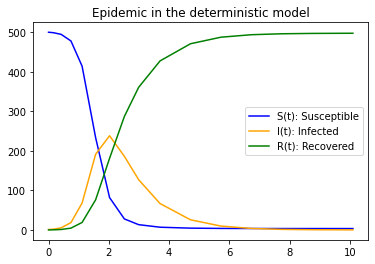

In [32]:
# Solving and plotting the system 
def f(t, y):
  return [-beta*y[1]*y[0]/N, beta*y[1]*y[0]/N - gamma*y[1], gamma*y[1]]

sol = solve_ivp(f, sol_interval, init_values)

x_axis_S = [sol.y.T[i][0] for i in range(len(sol.y.T))]
x_axis_I = [sol.y.T[i][1] for i in range(len(sol.y.T))]
x_axis_R = [sol.y.T[i][2] for i in range(len(sol.y.T))]

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(sol.t, x_axis_S, label='S(t): Susceptible', color = 'blue')
plt.plot(sol.t, x_axis_I, label='I(t): Infected', color = 'orange')
plt.plot(sol.t, x_axis_R, label='R(t): Recovered', color = 'green')
plt.legend(loc = 'best')
plt.title("Epidemic in the deterministic model")
plt.show()

## **Modèle SIR** - Stochastic Formulation 

Markov chain $(S(t), I(t), R(t), t ≥ 0)$, starting from $(S(0) = N − i_0, I(0) = i_0, R(0) = 0)$ with the following transition rates:

$$
\begin{array}{ll}
(S, I, R) → (S − 1, I + 1, R) & Rate_1 = \frac{\beta I S}{N}
\\
(S, I, R) → (S, I - 1, R + 1) & Rate_2 = \gamma I
\end{array}
$$

In [33]:
# Function that calculates the transition probabilities from their rates
def prob(rate1, rate2):

  Probab1 = rate1/(rate1+rate2)
  Probab2 = rate2/(rate1+rate2)
  
  num = rd.random()

  if num < Probab1:
    return 1
  else: return 2

In [34]:
# Epidemic Function
def Epidemie(N, tmax, i0, beta, gamma):

  S = np.zeros(tmax)  # Number of susceptibes for each instant t.
  I = np.zeros(tmax)  # Number of infected for each instant t.
  R = np.zeros(tmax)  # Number of immune for each instant t.
  T = np.zeros(tmax)  # Vector of time instants.

  # Declaration of the initial state:
  S[0] = N - i0
  I[0] = i0
  R[0] = 0
  T[0] = 0

  # Propagation of the epidemic:
  for i in range(tmax-1):
    # case where there are no more infected individuals
    if I[i] == 0:
      Tfin = T[i]  # end of the epidemic
      Rfin = R[i]  # size of the epidemic
      for j in range(i+1, tmax):
        S[j] = S[i]
        I[j] = I[i]
        R[j] = R[i]
        T[j] =  Tfin
      break

    # Transition rates
    Rate1 = beta*I[i]*S[i]/N
    Rate2 = gamma*I[i]
    Sum_Rates = Rate1 + Rate2

    # Time increase with the help of exponential clocks
    increment_temps = np.random.exponential(1/Sum_Rates)
    T[i+1] = T[i] + increment_temps

    # Probability function for the transition
    Transition = prob(Rate1, Rate2)

    # Transition
    if Transition == 1:
      S[i+1] = S[i] - 1
      I[i+1] = I[i] + 1
      R[i+1] = R[i]

    if Transition == 2:
      S[i+1] = S[i]
      I[i+1] = I[i] - 1
      R[i+1] = R[i] + 1

  return [T, S, I, R, Tfin, Rfin]

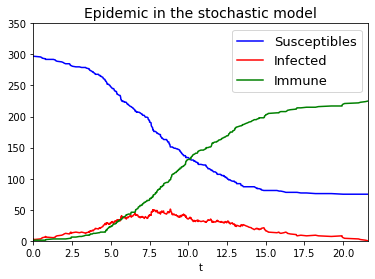

R0_critic = 1.0101010101010102
R0 = 2.0
End of the epidemic: 21.61026990694133
Size of the epidemic: 225.0


In [35]:
# Definition of the parameters 
N = 300      # size of the population
tmax = N*4   # Maximum nunber of transitions the markov chain will have
i0 = 3       # Initial number of infected individuals
beta = 1
gamma = 0.5

# Executing the Epidemic 
[T, S, I, R, Tfin, Rfin] = Epidemie(N, tmax, i0, beta, gamma)

# Plotting the curves
plt.plot(T, S, 'b', label = 'Susceptibles')
plt.plot(T, I, 'r', label = 'Infected')
plt.plot(T, R, 'g', label = 'Immune')

plt.axis([0, Tfin, 0, N+50])
plt.legend(loc="upper right", fontsize=13)
plt.xlabel("t")
plt.title("Epidemic in the stochastic model", fontsize=14)
plt.show()

print("R0_critic =", N/S[0])
print("R0 =", beta/gamma)
print("End of the epidemic:", Tfin)
print("Size of the epidemic:", Rfin)

### Estimation Models for $P(R(\infty) > K)$

From $K= 281$, we have the ocurrence of rare events.
Theoretical value calculated from $1,000,000$ Monte-Carlo simulations for **$K = 282$**:    $3.1$ x $10^{-5}$

#### $1$: Crude *Monte-Carlo* (**CMC**)

A starting point for the estimation of this probability is a naive Monte-Carlo method, by simulating until the end of the epidemic `N_CMC` composed independent processes $(X_i)_{T_end}$ of parameters $(\beta, \gamma)$ where the naif Monte-Carlo estimator is $$ \frac{1}{N_{CMC}} \sum_{i=1}^{N_{CMC}} \mathbb{1}_{\{R^i(\infty) > K\}}$$

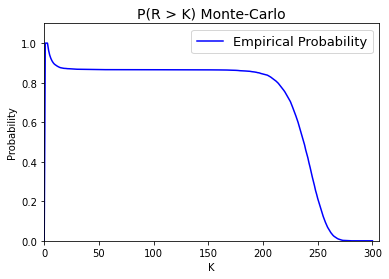

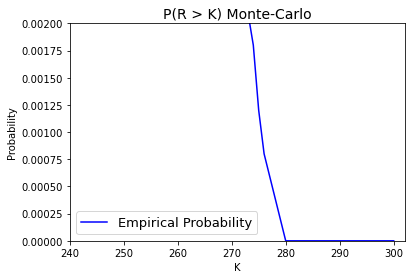

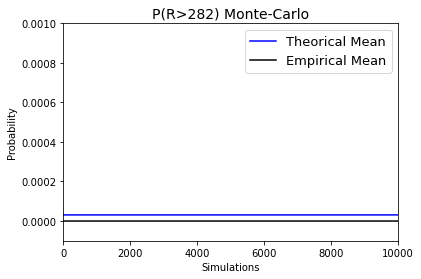

Mean = 0.0
P(R>282) = 0.0


In [36]:
Rep_CMC = int(1e4)             # Number of simulations
CMC = np.zeros(N+1)            # Probability vetors for each K
K_chosen = 282                 # K from P(R>K)
Prob_CMC = np.zeros(Rep_CMC+1) # Probability vectors for K = 280                 
Mean_CMC = 0                    # Average of R final

# Simulations de MC
for j in range(Rep_CMC):  
  [T, S, I, R, Time, Size] = Epidemie(N, tmax, i0, beta, gamma)
  CMC[int(Size)] = CMC[int(Size)] + 1
  if Size >= K_chosen:
    Prob_CMC[j+1] = (Prob_CMC[j]*j + 1)/(j+1)
  else: Prob_CMC[j+1] = Prob_CMC[j]*j/(j+1)
  Moy_CMC = Mean_CMC + Size

# Normalisation
CMC = CMC/Rep_CMC   
Mean_CMC = Mean_CMC/Rep_CMC

# Jusqu'à maintenant on a P(R=K), mais on veut P(R>K)
for i in range(1, N):
  CMC[N-i] = CMC[N-i] + CMC[N-i+1]

# Plotage des graphiques
x = np.linspace(0, N, N+1)
plt.plot(x, CMC, 'b', label = 'Empirical Probability')

plt.axis([0, N+N/50, 0, 1.1])
plt.legend(loc="best", fontsize=13)
plt.xlabel("K")
plt.ylabel("Probability")
plt.title("P(R > K) Monte-Carlo", fontsize=14)
plt.show()

z = np.linspace(0, N, N+1)
plt.plot(x, CMC, 'b', label = 'Empirical Probability')

plt.axis([N-N/5, N+2, 0, 0.002])
plt.legend(loc="best", fontsize=13)
plt.xlabel("K")
plt.ylabel("Probability")
plt.title("P(R > K) Monte-Carlo", fontsize=14)
plt.show()

y = np.linspace(0, Rep_CMC, Rep_CMC+1)
plt.plot(y, [0.000031]*(Rep_CMC+1), color = 'b', label = 'Theorical Mean')
plt.plot(y, Prob_CMC, color = 'black', label = 'Empirical Mean')

plt.axis([0, Rep_CMC, -0.0001, 0.001])
plt.legend(loc="best", fontsize=13)
plt.xlabel("Simulations")
plt.ylabel("Probability")
plt.title("P(R>282) Monte-Carlo", fontsize=14)
plt.show()
print('Mean =', Mean_CMC)
print('P(R>282) =', CMC[K_chosen])

In [37]:
# Variance 
Var = 0
for i in range(1, Rep_CMC+1):
  Var = Var + (Prob_CMC[i] - 0.000031)**2
Var = Var/Rep_CMC
print('Variance MC =', Var)

#Intervalle de confiance de 95%
bounds = 2*math.sqrt(Var/Rep_CMC)
print('95% Confidence Interval: [', Prob_CMC[-1] - bounds, Prob_CMC[-1] + bounds, ']')

Variance MC = 9.609999999999687e-10
95% Confidence Interval: [ -6.199999999999899e-07 6.199999999999899e-07 ]


Unfortunately, the Monte Carlo naive estimate does not give a good result because the event ${R(\infty)>280}$ has never happened on the `N_{CMC}` simulations, as verified by the second image above.

To get around this problem, an Importance Sampling technique is used.

#### **2**: Importance Sampling (**IS**)

This technique is a change of probability composed of the parameters $$\beta_{new} \geq \beta$$ $$\lambda_{new} \leq \lambda $$ 

The advantage of this change in probability is that the number of events of $R^i(\infty) > K$ will be greater, and consequently we can estimate the probability envisaged better. Furthermore, the $X_i$ has a new distribution with a larger mean and variance: $$\mathbb{E}_{\mathbb{new}} {[ \phi R_T] = \mathbb{E} [R_T]}$$ $$\text{Var}_{\mathbb{new}} {[ \phi R_T] = \text{Var} [R_T]} $$ where $\phi$ represents the value of the vraissamblance $(d\mathbb{P} / d\mathbb{P}_{new})$.

In [38]:
# Function that calculates the importance function (dP/dP_new)
def Fonc_Import(T, S, I, R, beta_actuel, gamma_actuel):
  # Calculating of N(t)
  Nt = 0
  for i in range(tmax):
    if T[i] == T[-1]:
      break
  Nt = i

  #Calculating the integral
  integrale = 0
  integrale_sup = 0
  integrale_inf = 0
  for t in range(Nt):
    integrale_sup = integrale_sup + (T[t+1]-T[t])*((beta - beta_actuel)*S[t]*I[t]/N + (gamma - gamma_actuel)*I[t])
    integrale_inf = integrale_inf + (T[t+1]-T[t])*((beta - beta_actuel)*S[t+1]*I[t+1]/N + (gamma - gamma_actuel)*I[t+1])
  integrale = (integrale_sup+integrale_inf)/2

  return (math.exp(-integrale))*((gamma/gamma_actuel)**R[-1])*((beta/beta_actuel)**(Nt-R[-1]))

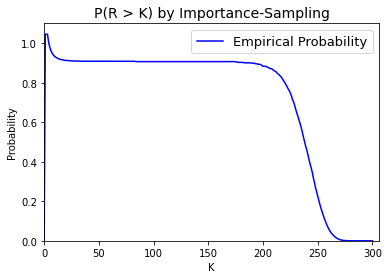

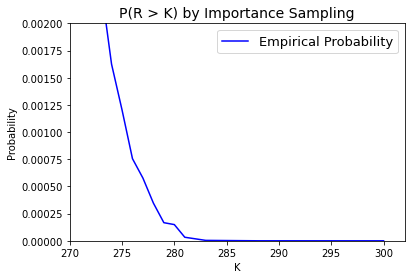

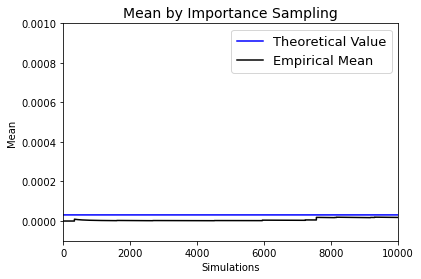

Mean = 0.0
P(R>282) IS = 1.8174646756472135e-05


In [39]:
Rep_IS = int(1e4)            # Number of simulations
IS = np.zeros(N+1)           # Probability vector for each K
Prob_IS = np.zeros(Rep_IS+1) # Probability vector for K = 280               
Mean_IS = 0                   # Mean IS

# New prameters
beta_new = 1.01
gamma_new = 0.4575

# Monte carlo simulations
for j in range(Rep_IS):  
  [T, S, I, R, Time, Size] = Epidemie(N, tmax, i0, beta_new, gamma_new)
  vraiss = Fonc_Import(T, S, I, R, beta_new, gamma_new) 
  IS[int(Size)] = IS[int(Size)] + vraiss
  if Size >= K_chosen:
    Prob_IS[j+1] = (Prob_IS[j]*j + vraiss)/(j+1)
  else: Prob_IS[j+1] = Prob_IS[j]*j/(j+1)
  Moy_IS = Mean_IS + Size*vraiss

# Normalisation
IS = IS/Rep_IS   
Mean_IS = Mean_IS/Rep_IS

# Until this point we have P(R=K), but we want P(R>K)
for i in range(1, N):
  IS[N-i] = IS[N-i] + IS[N-i+1]

#Plotage des graphiques
z = np.linspace(0, N, N+1)
plt.plot(x, IS, 'b', label = 'Empirical Probability')

plt.axis([0, N+N/50, 0, 1.1])
plt.legend(loc="best", fontsize=13)
plt.xlabel("K")
plt.ylabel("Probability")
plt.title("P(R > K) by Importance-Sampling", fontsize=14)
plt.show()

x = np.linspace(0, N, N+1)
plt.plot(x, IS, 'b', label = 'Empirical Probability')

plt.axis([N-N/10, N+2, 0, 0.002])
plt.legend(loc="best", fontsize=13)
plt.xlabel("K")
plt.ylabel("Probability")
plt.title("P(R > K) by Importance Sampling", fontsize=14)
plt.show()

y = np.linspace(0, Rep_IS, Rep_IS+1)
plt.plot(y, [0.000031]*(Rep_IS+1), color = 'b', label = 'Theoretical Value')
plt.plot(y, Prob_IS, color = 'black', label = 'Empirical Mean')

plt.axis([0, Rep_IS, -0.0001, 0.001])
plt.legend(loc="best", fontsize=13)
plt.xlabel("Simulations")
plt.ylabel("Mean")
plt.title("Mean by Importance Sampling", fontsize=14)
plt.show()
print('Mean =', Mean_IS)
print('P(R>282) IS =', IS[K_chosen])

Now the result is satisfactory and very close to the theoretical value of $3.1$ x $10^{-5}$

In [40]:
# Variance related to this probability
Var = 0
for i in range(1, Rep_IS+1):
  Var = Var + (Prob_IS[i] - 0.000031)**2
Var = Var/Rep_IS
print('Variance MC =', Var)

#Intervalle de confiance de 95%
bounds = 2*math.sqrt(Var/Rep_IS)
print('95% confidence interval: [', Prob_IS[-1] - bounds, Prob_IS[-1] + bounds, ']')

Variance MC = 6.417702461621874e-10
95% confidence interval: [ 1.7667983062820332e-05 1.868131045012391e-05 ]


As we can see, the variance using Importance Sampling is lower than the one using Monte-Carlo, which proves the best efficiency of this implementation.

To find the optimal parameters $\beta$ et $\gamma$, we could implement an iterative algorithm, which will not be done in this project due to the huge difficulty.

### How does $P(R(\infty) > K)$ evolve with $R_0$?

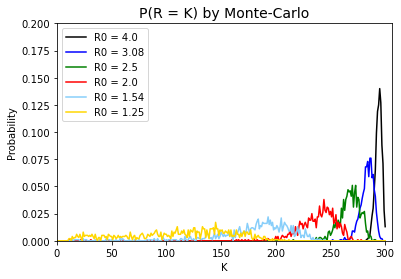

In [41]:
# Redefinition of the parameters
i0 = 10
beta = 1.0
values_gamma = np.array([0.25, 0.325, 0.4, 0.5, 0.65, 0.8])
Rep_CMC = int(1e3)
CMC = np.zeros(N+1)
x = np.linspace(0, N, N+1)
colors=['k','blue', 'green', 'red', 'lightskyblue', 'gold', 'yellowgreen']

for i in range(6):
  gamma = values_gamma[i]
  CMC = np.zeros(N+1)

  #Simulations de MC
  for j in range(Rep_CMC):  
    [T, S, I, R, Time, Size] = Epidemie(N, tmax, i0, beta, gamma)
    CMC[int(Size)] = CMC[int(Size)] + 1
  
  #Normalisation
  CMC = CMC/Rep_CMC

  #Plotage
  plt.plot(x, CMC, colors[i])

plt.axis([0, N+N/50, 0, 0.2])
plt.legend(['R0 = 4.0', 'R0 = 3.08', 'R0 = 2.5', 'R0 = 2.0', 'R0 = 1.54', 'R0 = 1.25'], loc = 'upper left')
plt.xlabel("K")
plt.ylabel("Probability")
plt.title("P(R = K) by Monte-Carlo", fontsize=14)
plt.show()

We see in the above image that the law of $R(\infty)$ converges to a poisson distribution.